# Towards a better model of asset returns: non-constant volatility

Here we plan to see how the classical model of Geometric Brownian Motion (GBM) compares to real asset prices and perhaps improve upon it. 3777 daily Apple prices have been collected from Quandl.com, spanning 15 years from the beginning of 2002 to the beginning of 2017. The function PlotPrices() below illustrates these data.

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def importData():
        
    path = "AAPL-LONG" + ".csv"
    market_data = pd.read_csv(path, index_col = 'Date', parse_dates = True)["Adj_Close"]
    
    startDate = datetime(2002,1,1)
    endDate = datetime(2017,1,1)
    daterange = pd.date_range(startDate, endDate)
    
    market_data = market_data[daterange].dropna()
        
    return market_data

def PlotPrices():
    
    marketData = importData()
        
    plt.plot(marketData.index, list(marketData))
        
    plt.style.use(['bmh'])
    plt.suptitle("Daily Apple Asset Prices", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    ax = plt.axes()
    ax.xaxis.set_major_locator(plt.LinearLocator())
        
    plt.show()    

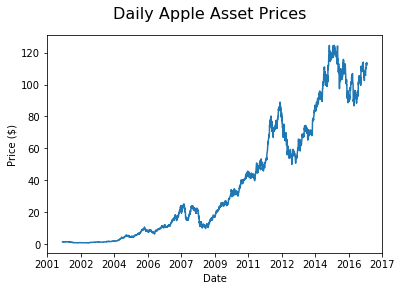

In [2]:
PlotPrices()

The first thing to notice is that prices are clearly not stationary, since the mean of the underlying process is not constant. To combat this, a common approach is not to focus on the absolute prices but on the price returns.

Recall that the GBM model stipulates that asset prices, $S$, follow:

$\frac{dS}{S} = \mu dt + \sigma dW$

where $W$ is a Weiner process, that, over a small period of time $dt$, changes with distribution: $dW \sim N(0,dt)$. These changes are independent of one another.

This can be discretised to give:

$\frac{S(t+\Delta t) - S(t)}{S(t)} = \mu \Delta t + \sigma \Delta W$

In our case $\Delta t =1$day, and we will approximate the small daily percentage returns as logarithmic returns:

$r_t = \ln(S_{t}) - \ln(S_{t-1}) = \mu + \sigma \epsilon_t$ $\qquad$ where $\epsilon_t \sim N(0,1)$ and are independent of one another.

The function PlotReturns() below illustrates the Apple logarithmic returns.

In [3]:
def returns():
    
    market_data = importData()
    
    returns_data = np.log( market_data ) - np.log( market_data.shift(1) )
    
    returns_data = returns_data.dropna()
        
    return returns_data

def calculateMoments( data ):
    
    mean = np.mean(data)
    std = np.std(data)
    skew = np.mean( ( (data - mean)**3 ) / (std**3) )
    kurtosis = np.mean( ( (data - mean)**4 ) / (std**4) )
    
    return [ mean, std, skew, kurtosis ]

def PlotReturns():
    
    returns_data = returns()
    
    plt.plot(returns_data.index, list(returns_data))
        
    plt.style.use(['bmh'])
    plt.suptitle("Daily Apple Logarithmic Returns", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Logarithmic Returns")
    ax = plt.axes()
    ax.xaxis.set_major_locator(plt.LinearLocator())
        
    plt.show()
    
    [ mean, std, skew, kurtosis ] = calculateMoments( returns_data )
    
    print("Returns Summary Statistics:\n")
    
    string_1 = " Mean: {:.6f}\n Standard Deviation: {:.6f}\n".format(mean, std)
    string_2 = " Skew: {:.6f}\n Kurtosis: {:.6f}\n".format(skew, kurtosis)
    print( string_1 + string_2 )

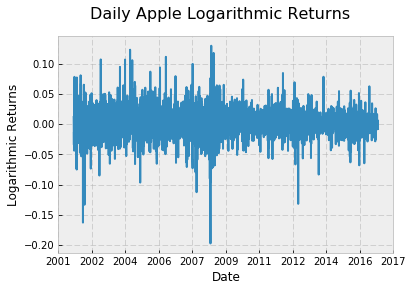

Returns Summary Statistics:

 Mean: 0.001148
 Standard Deviation: 0.022499
 Skew: -0.178401
 Kurtosis: 8.363240



In [5]:
PlotReturns()

The returns data appears to oscillate around a constant mean of approximately zero - perhaps to be expected of daily returns. To a first approximation we will assume $\mu \approx 0$.

The negative skew hints that returns might not be simple realisations of a Normal distribution, which is symmetric and so has a skew of zero. This is as a result of prolonged periods of negative returns during times of financial crisis - 2008 being particularly visible here. Similarly the kurtosis is much larger than that for a Normal distribution, theoretically equal to 3, and indicates that the returns distribution has fatter tails. Such distributions are called leptokurtic.

Assuming the stationary GBM model of returns, we would have:

$r_t = 0.022499\epsilon_t \quad \implies \quad \ln(S_t) = \ln(S_{t-1}) + 0.022499\epsilon_t$

Note that this models prices as a Markovian process, since $S_t$ solely depends on the previous price, $S_{t-1}$, and the $\epsilon_t$ are independent. More formally:

$P(S_t|S_{t-1}, S_{t-2},...,S_0) = P(S_t|S_{t-1})$

This would be true regardless of the value of $\mu$. The GBM model also implies that the logarithm of price is a martingale, since the expectation of $\ln(S_{t})$ solely depends on and is equal to $\ln(S_{t-1})$. More formally:

$E(\ln(S_t)|\ln(S_{t-1}), \ln(S_{t-2}),...,\ln(S_0)) = E(\ln(S_{t-1}) + 0.022499\epsilon_t) = \ln(S_{t-1})$

Note that this requires $\mu = 0$. These two properties effectively formalise the weak form of the Efficient Market Hypothesis (EMH): the notion that historical prices are useless at predicting the future and instead the current asset price reflects all available information.

The function TimeSeriesAnalysis below compares this idealised model to the data.

In [4]:
from statsmodels.graphics import tsaplots
import scipy.stats as stats

def TimeSeriesAnalysis():
    
    returns_data = returns()
    n = len(returns_data)
    [ mean, std, skew, kurtosis ] = calculateMoments( returns_data )
    sorted_data = sorted(list(returns_data))
        
    plt.style.use(['bmh'])
    fig = plt.figure( figsize = (15, 10) )
    layout = (2, 2)
    max_lags = 30
    
    time_series_ax = plt.subplot2grid(layout, (0, 0))
    histo_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    returns_data.plot( ax = time_series_ax )
    GBM_returns = pd.DataFrame( np.random.normal(mean, std, n) )
    GBM_returns.index = returns_data.index
    GBM_returns.plot( ax = time_series_ax, alpha = 0.4 )
    time_series_ax.set_title("Daily Apple Logarithmic Returns")
    time_series_ax.set_xlabel("Date")
    time_series_ax.set_ylabel("Logarithmic Returns")
    time_series_ax.legend(["AAPL", "GBM Model"])
    
    returns_data.hist( ax = histo_ax, normed=True, bins = 30)
    fit = stats.norm.pdf(sorted_data, mean, std)
    histo_ax.plot(sorted_data, fit, '-')
    histo_ax.set_title("Distribution of daily Apple logarithmic returns")
    
    tsaplots.plot_acf( returns_data , lags = max_lags, ax = acf_ax, alpha = 0.05 )
    acf_ax.set_ylim([-0.1, 0.1])
    
    tsaplots.plot_pacf( returns_data , lags = max_lags, ax = pacf_ax, alpha = 0.05 )
    pacf_ax.set_ylim([-0.1, 0.1])

    plt.tight_layout()
    plt.show()

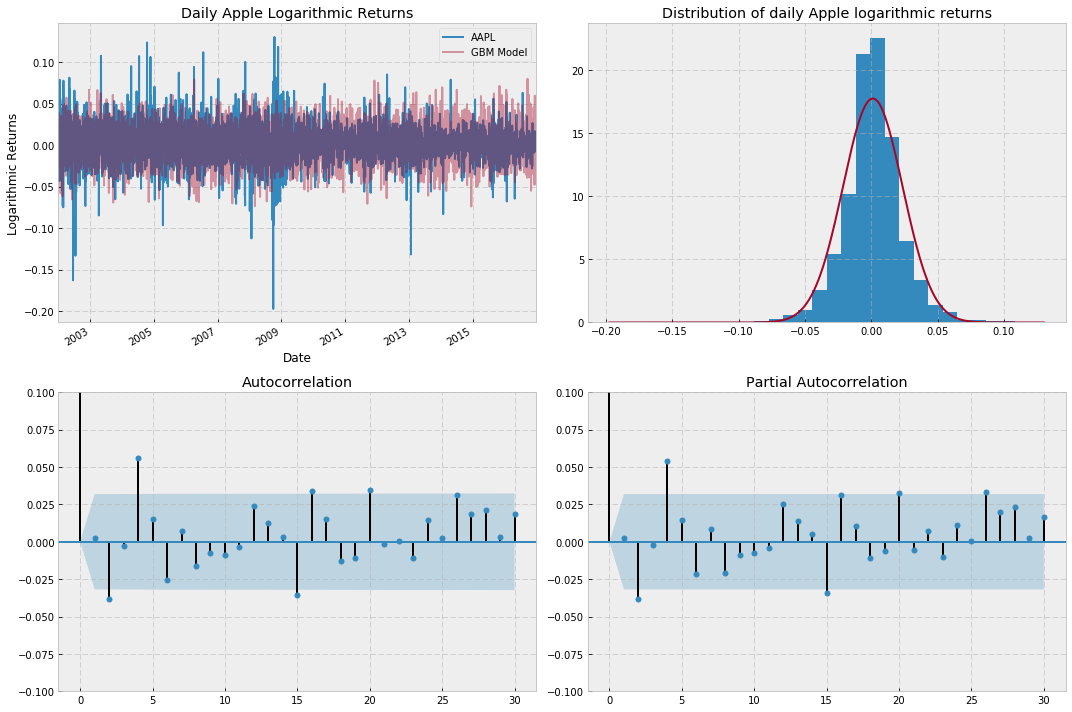

In [9]:
TimeSeriesAnalysis()

The time series graph clearly shows the stationary nature of the GBM model, varying about the mean within a roughly constant range. The Apple data, however, appears to go through periods of comparatively low and then high volatility. This is shown even more clearly in the histogram. The GBM model will effectively never predict a return with a magnitude of greater than 0.07, despite Apple achieving this several times since 2002. It also fails to model the more concentrated returns around the origin.

It is well documented that returns data can be modelled much more accurately using a Student's t-distribution. It can be shown that the t-distribution is a mixture of Normal distributions: each with the same mean but with variances sampled from an Inverse Gamma distribution. In other words, the t-distribution can be viewed as a Normal distribution with a variance that jumps around. This simultaneously accounts for its more concentrated centre (when the sampled variance is low) and fatter tails (when the sampled variance is high).

This is a useful approach if one wants to model the static returns distribution, but it will fail to capture the price dynamics illustrated in the bottom two plots.

**Moving Average Model**

The autocorrelation, ${\rho_k}$, of a time series, ${r_t}$, at lag $k$ is simply the correlation of the time series with a delayed version of itself:

$\rho_k = \frac{\text{cov}(r_{t+k}, r_t)}{\sigma^2}$

Clearly $\rho_0 = 1$. The Apple autocorrelation function (ACF) is plotted above for the first 30 lags, alongside its 5% significance region centred on zero. This boundary is breached 3 times in just the first 30 lags, albeit not by large amounts. There appear to be long-term memory effects at lags 2, 4 and 15. This directly conflicts with the EMH and suggests that GBM is not adequate to model the data.

A Moving Average process of order $q$, MA($q$), has the form:

$r_t = \mu + \sigma\epsilon_t + \theta_1\sigma\epsilon_{t-1} + ... + \theta_q\sigma\epsilon_{t-q}$ $\qquad$ where $\epsilon_t \sim N(0,1)$ and are independent of one another.

This is a stationary process with constant mean and variance. When compared to our previous model it can be seen as a generalisation of GBM: a MA(0) model. These added *shock* terms model memory effects; for example $\epsilon_0$ has a direct effect on returns $r_0, r_1, ... r_q$.

It can be shown that an MA($q$) process has a non-zero ACF before lag $q$, for the duration that a single shock affects several returns, and a zero ACF afterwards: $\rho_k = 0$ for $k>q$. This doesn't really seem to fit the Apple ACF illustrated above.

**Autoregressive Model**

An Autoregressive process of order $p$, AR($p$), has the form:

$r_t = \mu + \phi_1r_{t-1} + ... + \phi_pr_{t-p} + \sigma\epsilon_t$ $\qquad$ where $\epsilon_t \sim N(0,1)$ and are independent of one another.

Th stationarity of this process depends on the values of the coefficients $\{\phi_i\}$. AR processes model more direct dependences between returns; for example $r_0$ has a direct effect on returns $r_1, r_2, ... r_p$. Unlike an MA process, where the memory only survives for a finite number of lags, in an AR process this dependence stretches infinitely into the future: $r_0$ directly affects $r_p$, $r_p$ directly affects $r_{2p}$, $r_{2p}$ directly affects $r_{3p}$, etc. Thus $r_0$ indirectly affects every future return. If the process is stationary then this effect decays with time.

For this reason the ACF of an AR model decays slowly to zero.

The partial correlation between two random variables $X$ and $Y$ given a set of $n$ controlling variables $\boldsymbol{Z} = \{Z_1, ... Z_n\}$ is the correlation between the residuals $\epsilon_X$ and $\epsilon_Y$ that result from the linear regression of $X$ with $\boldsymbol{Z}$ and $Y$ with $\boldsymbol{Z}$, respectively. This enables one to find the correlation between $X$ and $Y$ whilst accounting for confounding variables.

The concept of partial correlation is exactly what we need to distinguish an AR process. The partial autocorrelation function (PACF) at lag $k$, $\gamma_k$, finds the correlation between a times series, $r_t$, and a lagged version of itself, $r_{t+k}$, whilst controlling for the indirect effects caused by terms at shorter lags. For this reason, the PACF of an AR process mimics the ACF of an MA process. It can be shown that the PACF of an AR($p$) process satsifies: $\phi_k = 0$ for $k>p$.

The Apple PACF is plotted above for the first 30 lags, alongside its 5% significance region centred on zero. It looks very similar to the ACF though there are slight differences. Again it indicates weak long-term memory effects even controlling for indirect dependencies. An AR process does not seem like it would fit this data well.

**ARMA Model**

An Autoregressive-Moving Average process combines an AR($p$) and a MA($q$) model to give an ARMA($p,q$) process:

$r_t = \mu + \sigma\epsilon_t + [\theta_1\sigma\epsilon_{t-1} + ... + \theta_q\sigma\epsilon_{t-q}] + [\phi_1r_{t-1} + ... + \phi_pr_{t-p}]$  $\qquad$ where $\epsilon_t \sim N(0,1)$ and are independent of one another.

ARMA processes are much less easy to diagnose by eye, though statistical procedures exist to optimally select $p$ and $q$.

**Volatility Clustering**

It has already been noted that the volatility of Apple returns itself seems to display some memory: clustering into areas of high and low volatility. There is an economic case for this phenomenon: if volatility increases, even with no particular direction, then this can cause risk-averse investors who were looking for predictable returns to close out their positions, thus increasing volatility even more.

Going back to the discrete GBM model:

$r_t = \mu + \sigma\epsilon_t$  $\quad$ where $\epsilon_t \sim N(0,1)$ and are independent of one another.

The model assumes that returns have a constant variance or are *unconditionally homoscedastic*: $\text{var}(r_t) = \text{E}[(r_t-\mu)^2]= \sigma^2$. This is guaranteed since the $r_t$ are identically distributed. More specifically, returns are also *conditionally homoscedastic* (CH): $\text{E}[(r_t-\mu)^2|r_{t-1}, r_{t-2},...]= \sigma^2$. This is guaranteed since the $r_t$ are also independent of one another.

The function VolAnalysis() below produces plots for the square mean-adjusted returns: $(r_t-\mu)^2$

In [5]:
def VolAnalysis():
    
    returns_data = returns()
        
    sq_returns = (returns_data - np.mean(returns_data) )**2
    
    plt.style.use(['bmh'])
    
    fig = plt.figure( figsize = (15, 5) )
    sq_returns.plot()
    plt.suptitle("Daily Apple Square Mean-Adjusted Logarithmic Returns", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Square Logarithmic Returns")
    time_ax = plt.axes()
    time_ax.xaxis.set_major_locator(plt.LinearLocator())
    time_ax.set_ylim([0, 0.04])
    plt.show()
    
    fig = plt.figure( figsize = (15, 10) )
    layout = (2, 2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    max_lags = 30
    
    tsaplots.plot_acf( sq_returns , lags = max_lags, ax = acf_ax, alpha = 0.05 )
    
    tsaplots.plot_pacf( sq_returns , lags = max_lags, ax = pacf_ax, alpha = 0.05 )

    plt.tight_layout()
    plt.show()

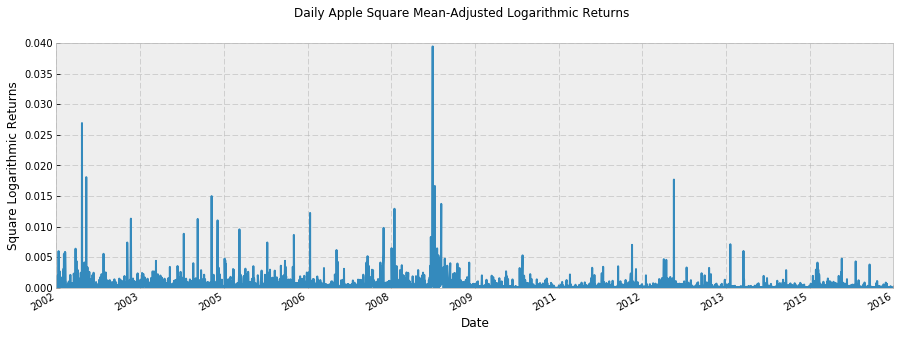

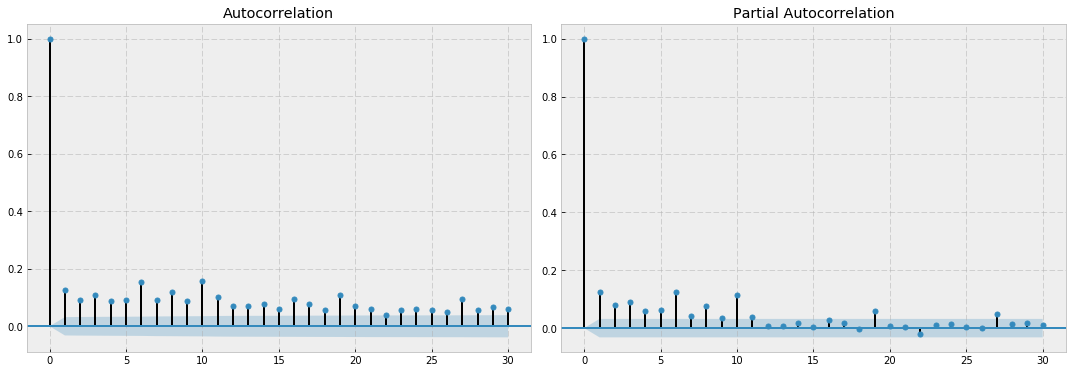

In [74]:
VolAnalysis()

The ACF and PACF for the squared returns clearly display statistically significant autocorrelation. Thus *heteroscedasticity*, or non-constant volatility, may account for the weak long-term memory effects that we found in the asset returns. The plots don't seem to match that of solely an AR or MA process. Nevertheless, an ACF that appears to never reach zero hints at an autoregressive component.

There is a systematic way to select between rival models. The function OptimalARMAOrder() below begins by fitting every possible ARMA process to the square returns with orders between (0,0) and (4,4).

It does this using the frequentist technique of *maximum likelihood estimation*. This assumes that there is one true model: $r_t = \sigma_t\epsilon_t$ where $\sigma_t$ is now no longer constant but some ARMA process with parameters $\boldsymbol{\theta}$. The data are merely random samples from this objective truth and its parameters can be estimated by maximising $\mathcal{L}(\boldsymbol{\theta}) = \text{P}(\boldsymbol{r}|\boldsymbol{\theta})$. This is often a multi-dimensional iterative search and so can be quite computationally intensive.

Once each model has been fit, two different techniques are used to estimate the optimality of each one with respect to the data.

**Akaike Information Criterion**

The Akaike Information Criterion (AIC) is a frequentist estimate of the information lost, as measured by change in entropy, in using the proposed model as opposed to the theoretically true distribution. Where $c$ is the number of parameters in the proposed model and $\widehat{L}$ is the maximum value of $\mathcal{L}$, this can be computed by:

$\text{AIC} = 2c - 2\ln(\widehat{L})$

Hence the model with the minimum AIC, or information loss, is selected as the optimal. Quite simply it can be seen as a trade-off between maximising fit ($2\ln(\widehat{L})$) whilst penalising over-fitting with too many parameters ($2c$).

**Bayesian Information Criterion**

The Bayesian Information Criterion (BIC) is a measure of how unlikely it is that a proposed model is the theoretically true distribution. As its name suggests, it takes a Bayesian approach that now assumes the data is fixed and constant but treats models, and specifically their parameters, as random variables. It can be shown that the model minimising the BIC in turn maximises the *posterior distribution* $\text{P}(\boldsymbol{\theta}|\boldsymbol{r})$, for some suitably general choice of prior distribution. Where $n$ is the number of data points, this can be computed by:

$\text{BIC} = c\ln(n) - 2\ln(\widehat{L})$

The BIC over-fitting penalty ($c\ln(n)$) is larger than that of AIC and hence it usually selects simpler models. As a model selection tool, it can be shown that AIC is asymptotically equivalent to leave-one-out cross validation. It is often suggested that AIC selects models that are best for prediction, as it optimises for the best fit to the data, whilst BIC selects models that are best for explanation, as it optimises for the most likely data-generating process.

In [6]:
import statsmodels.tsa as tsa

def OptimalARMAOrder():
    
    max_order = 5
    returns_data = returns()
    sq_returns = (returns_data - np.mean(returns_data) )**2
    
    AIC = np.zeros( (max_order, max_order) )
    BIC = np.zeros( (max_order, max_order) )
    
    for p in range(0, max_order ):
        for q in range(0, max_order ):
            print("Fitting order ({},{})".format(p, q))
            model = tsa.arima_model.ARMA( sq_returns, (p, q) )
            model = model.fit(maxiter=200, method='css-mle', solver='bfgs', disp=0)
            AIC[p,q] = model.aic
            BIC[p,q] = model.bic
                
    min_aic = np.unravel_index( np.argmin(AIC), np.shape(AIC) )
    min_bic = np.unravel_index( np.argmin(BIC), np.shape(BIC) )
    
    print("")
    print( "AIC optimal ARMA process order: {}".format(min_aic) )
    print( "BIC optimal ARMA process order: {}".format(min_bic) )

In [12]:
OptimalARMAOrder()

Fitting order (0,0)
Fitting order (0,1)
Fitting order (0,2)
Fitting order (0,3)
Fitting order (0,4)
Fitting order (1,0)
Fitting order (1,1)
Fitting order (1,2)
Fitting order (1,3)
Fitting order (1,4)
Fitting order (2,0)
Fitting order (2,1)
Fitting order (2,2)
Fitting order (2,3)
Fitting order (2,4)
Fitting order (3,0)
Fitting order (3,1)
Fitting order (3,2)
Fitting order (3,3)
Fitting order (3,4)
Fitting order (4,0)
Fitting order (4,1)
Fitting order (4,2)
Fitting order (4,3)


/Users/Tom/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:492: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/Tom/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Tom/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Tom/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:494: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/Tom/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Tom/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Tom/anaconda/lib/python3.6/site

Fitting order (4,4)

AIC optimal ARMA process order: (4, 3)
BIC optimal ARMA process order: (1, 1)


As expected, the BIC selects a simpler model. No doubt AIC would pick an even more complex model had the search been wider. Since it is always good to start simple, we will attempt to model volatility as an ARMA(1,1) process.

**GARCH**

A simple method for estimating realised volatility, assuming a zero mean, is to look back over a window of $p$ previous periods:

$\sigma_t^2 = \sum_{1}^{p}\frac{1}{p}r_{t-i}^2$

This treats all of the previous periods in the window equally. A more general technique might weight recent observations more heavily than older ones:

$\sigma_t^2 = \sum_{1}^{p}\alpha_i r_{t-i}^2$ $\quad$ where $\sum \alpha = 1,$ $\alpha_i > \alpha_j$ $\forall i<j$ and $\alpha_i > 0$ $\forall i$

It should be noted that volatility, unlike asset prices, does not continually grow or sink. Instead it is more like an interest rate, varying about some long-run average. For instance, the long-run average volatility of S&P 500 is around 12%. Incorportating this into the model:

$\sigma_t^2 = \gamma\omega + \sum_{1}^{p}\alpha_i r_{t-i}^2$ $\quad$ where $\gamma + \sum \alpha = 1$

$\gamma$ is the positive weight assigned to the long-run average, $\omega$. This is known as an ARCH($p$) model (Autoregressive Conditional Heteroscedasticity). One can show that it is conditionally heteroscedastic since $\text{var}(r_t|r_{t-1}, ...)$ varies with $t$:

$\text{var}(r_t|r_{t-1}, ...) = \text{E}[(r_t-\mu)^2|r_{t-1}, ...] = \text{E}(\sigma_t^2\epsilon_t^2|r_{t-1}, ...) = \text{E}(\sigma_t^2|r_{t-1}, ...)\text{E}(\epsilon_t^2|r_{t-1}, ...)$

$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\;\;\,=\text{E}(\sigma_t^2|r_{t-1}, ...)\times 1$

$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\;\;\,=\gamma\omega + \sum_{1}^{p}\alpha_i r_{t-i}^2$

It is described as autoregressive since the conditional variance of returns is a function of the returns themselves at the previous $p$ periods: an AR($p$) process.

A GARCH($p$,$q$) (Generalised Autoregressive Conditional Heteroscedasticity) process takes this one step further and models the conditional variance as an $\text{ARMA}(p, q)$ process:

$\sigma_t^2 = \gamma\omega + \sum_{1}^{p}\alpha_i r_{t-i}^2 + \sum_{1}^{q}\beta_i \sigma_{t-i}^2$ $\quad$ where $\gamma + \sum \alpha + \sum \beta = 1$

Specifically, our analysis of the Apple data above hinted at a GARCH(1,1) model:

$\sigma_t^2 = \gamma\omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$ $\quad$ where $\gamma + \alpha + \beta = 1$

Again this model is conditionally heteroscedastic, following similar steps to above, since the conditional variance is a function of $t$:

$\text{var}(r_t|r_{t-1}, ...) = \gamma\omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$

One can derive a recurrence relation for the unconditional variance and solve it to get:

$\text{var}(r_t) = \text{E}[(r_t-\mu)^2] = \text{E}(\text{E}[(r_t-\mu)^2|r_{t-1}, ...]) = \text{E}(\gamma\omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2) = \gamma\omega + \alpha\text{E}(r_{t-1}^2) + \beta\text{E}(\sigma_{t-1}^2)$

$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad\;\;\,\,=\gamma\omega + \alpha\text{var}(r_{t-1}) + \beta\text{E}(\sigma_{t-1}^2\epsilon_{t-1}^2)$

$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad\;\;\,\,=\gamma\omega + (\alpha + \beta)\text{var}(r_{t-1})$

$\implies \text{var}(r_t) = A(\alpha + \beta)^t + \frac{\gamma \omega}{1-\alpha-\beta} = A(\alpha + \beta)^t + \omega$ $\qquad$ where $A$ is some arbitrary constant

This is the volatility term structure. So long as $\alpha + \beta < 1$, then as $t\rightarrow\infty$, $\text{var}(r_t)\rightarrow\omega$. Under this condition the volatility is mean-reverting and disturbances decay away. Therefore the asset returns process is stationary with a constant volatility or, more formally, is unconditionally homoscedastic.

It should be noted that a GARCH process is not truly a model of *stochastic volatility* since at time $t$ the volatility is completely predetermined by previous values. This is because no new sources of randomness are introduced into the model.

A continuous analogue of the GARCH model can be derived to compare it to GBM, considering $\mu=0$ for simplicity. Since $r_t = \sigma_t\epsilon_t$ where $\epsilon_t \sim N(0,1)$ and are independent of one another, we know that $\text{E}(r_t)=0$ and $\text{E}(r_t^2)=\sigma_t^2$. By Normality we also have: $\text{E}(r_t^4)=3\sigma_t^4$. Thus:

$\text{var}(r_t^2) = \text{E}(r_t^4) - \text{E}(r_t^2)^2 = 2\sigma_t^4$

and so $r_t^2$ has a standard deviation of $\sqrt{2}\sigma_t^2$. Therefore the process for $r_t^2$ can be written as $r_t^2 = \sigma_t^2 + \sqrt{2}\sigma_t^2\epsilon_t$. Substituting this into the GARCH iteration and rearranging:

$\sigma_t^2 - \sigma_{t-1}^2 = \gamma\omega + (\alpha + \beta -1)\sigma_{t-1}^2 + \sqrt{2}\sigma_{t-1}^2\epsilon_{t-1}=\gamma(\omega - \sigma_{t-1}^2) + \sqrt{2}\sigma_{t-1}^2\epsilon_{t-1} $

Now let $\nu=\sigma_{t-1}^2$, $\Delta\nu = \sigma_t^2 - \sigma_{t-1}^2$ and $\Delta t =1$day:

$\Delta\nu = \gamma(\omega - \nu)\Delta t + \sqrt{2}\nu\Delta W$ $\quad$ where $W$ is a discretised Weiner process $\Delta W \sim N(0,\Delta t)$

Finally taking the continuous limit $\Delta t \rightarrow 0$, we have the full asset price dynamics:

$\frac{dS}{S} = \sqrt{\nu}dW$, $\quad$ $d\nu = \gamma(\omega - \nu)dt + \sqrt{2}\nu dW$

Again, note that the same Weiner process provides the source of randomness for the asset returns and the volatility.

**Calibration**

There are two potential techniques for fitting a GARCH model to our Apple data: MLE and GMM.

**Maximum Likelihood Estimation**

This is the method that the function OptimalARMAOrder() used. We will create our own version of this built-in implementation.

Since each return is Normally distributed, $r_t \sim N(\mu, \sigma_t^2)$, we will use the Normal pdf:

$\text{P}(r_t|\gamma, \omega, \alpha, \beta) = \frac{1}{\sqrt{2\pi\sigma_t^2}}\exp(\frac{-(r_t-\mu)^2}{2\sigma_t^2})$

Since the $\epsilon_t$ are independent, the likelihood function for the entire data set can then be written as:

$\mathcal{L}(\gamma, \omega, \alpha, \beta) = \prod_{t=1}^{n}\frac{1}{\sqrt{2\pi\sigma_t^2}}\exp(\frac{-(r_t-\mu)^2}{2\sigma_t^2})$

It is often easier to work with the log-likelihood function. Dropping constants that have no effect on the maximum estimations:

$\ln(\mathcal{L}) = -\sum_{t=1}^n \big( \frac{1}{2}\ln(\sigma_t^2) + \frac{(r_t-\mu)^2}{2\sigma_t^2} \big)$

We will let $\omega = \text{E}(r_t^2)$, the long-run variance over the whole data set. This same value will also be our initial variance: $\sigma_1^2$. Lastly, noting that $\gamma = 1- \alpha-\beta$, the log-likelihood becomes a function of just two variables: $\boldsymbol{\theta} = [\alpha, \beta]$.

The function negativeLogLikelihood() below computes $-\ln(\mathcal{L})$ for a given $\boldsymbol{\theta}$. It returns the negation so that minimising this function matches our aim of maximising the log-likelihood. It also scales the objective function so that the solver remains stable. The MLECalibration() function imposes three constraints: $\alpha>0$, $\beta>0$, $\alpha+\beta<1$, this last condition guarantees that $\gamma>0$. Finally the log-likelihood is iteratively maximised using a Sequential Least Squares Programming (SLSQP) optimisation algorithm with initial guesses $\boldsymbol{\theta} = [0.2, 0.3]$.

In [7]:
import scipy.optimize as optimize

def computeVolSeries(returns, initial_var, theta):
    
    n = len(returns)
    variance = [0]*n
    
    variance[0] = initial_var
    
    alpha = theta[0]
    beta = theta[1]
    
    for t in range(1,n):
        variance[t] = (1 - alpha - beta)*initial_var + alpha*returns[t-1]**2 + beta*variance[t-1]
        
    return variance

def negativeLogLikelihood(theta):
    
    r = returns()
    mu = np.mean(r)
    n = len(r)
    initial_var = np.std(r - mu)**2
    
    var = computeVolSeries(r, initial_var, theta)
        
    negative_log_likelihood = sum( [ 0.5*np.log(var[t]) + (r[t] - mu)**2 / ( 2*var[t] ) for t in range(n)] )
    
    scaled_objective = 0.001 * negative_log_likelihood
    
    return scaled_objective

def MLECalibration():
    
    def constraint1(theta):
        return np.array([1 - theta[0] - theta[1]])
    
    def constraint2(theta):
        return np.array(theta[0])
    
    def constraint3(theta):
        return np.array(theta[1])
    
    constraints = ({'type': 'ineq', 'fun': constraint1},
                   {'type': 'ineq', 'fun': constraint2},
                   {'type': 'ineq', 'fun': constraint3})
    
    def callback(theta):
        print("alpha = {:.8f}, beta = {:.8f}".format(theta[0], theta[1]))
            
    result = optimize.minimize( negativeLogLikelihood, 
                                (0.2, 0.3),
                                method='SLSQP',
                                constraints=constraints,
                                callback=callback )
                               
    print("\n MLE parameters after {} iterations:\n".format(result.nit))
    
    string1 = " alpha = {:.8f} \n beta = {:.8f} \n".format(result.x[0], result.x[1])
    string2 = " gamma = {:.8f}".format(1 - result.x[0] - result.x[1])
    
    print(string1 + string2)

In [66]:
MLECalibration()

alpha = 0.39770133, beta = 0.48653774
alpha = 0.31433446, beta = 0.68566554
alpha = 0.27022179, beta = 0.72977821
alpha = 0.25456750, beta = 0.74543250
alpha = 0.24187225, beta = 0.75812775
alpha = 0.22918201, beta = 0.77081799
alpha = 0.21626777, beta = 0.78373223
alpha = 0.20245477, beta = 0.79754523
alpha = 0.18669848, beta = 0.81330152
alpha = 0.16720298, beta = 0.83279702
alpha = 0.14047315, beta = 0.85952685
alpha = 0.09618907, beta = 0.90381093
alpha = 0.00972639, beta = 0.99027361
alpha = 0.02939669, beta = 0.97060331
alpha = 0.05568475, beta = 0.94431525
alpha = 0.02664903, beta = 0.97335097
alpha = 0.04327969, beta = 0.94958395
alpha = 0.04726935, beta = 0.94177719
alpha = 0.04801068, beta = 0.94162436
alpha = 0.04638308, beta = 0.94395653
alpha = 0.04670826, beta = 0.94345928
alpha = 0.04670826, beta = 0.94345928

 MLE parameters after 22 iterations:

 alpha = 0.04670826 
 beta = 0.94345928 
 gamma = 0.00983246


Note that MLE computes $\beta$, the MA weighting, to be an order of magnitude larger than $\alpha$, the AR weighting, which is in turn an order of magnitude larger than $\gamma$, the long-run average weighting.

**Generalised Method of Moments**

Method of Moments (MM) is a technique for estimating model parameters. The traditional procedure begins by deriving the first $k$ moments of the theoretical model (mean, variance, skew, kurtosis...) in terms of the $k$ parameters to be estimated, $\boldsymbol{\theta}$. Next one matches these expressions with estimates from the data and solves the resulting $k$ equations for the parameters. This technique often produces biased estimates and is known to be unrobust. MLE is a superior method in these respects, but does require one to specify the full model distribution. For this reason MM is often used for semi-parametric model estimation.

GMM addresses some of the inadequacies of MM. Its moment matching equations take the form of *moment conditions*. These are moments that should be equal to zero under the theoretical model: $m(\boldsymbol{\theta}) = \text{E}[g(r_t;\boldsymbol{\theta})]=0$ where $g(r_t;\boldsymbol{\theta})$ is some function of the model. Rather than focussing on the moments of the returns, $r_t$, we will match the moments of the residuals, $\epsilon_t = (r_t - \mu)/ \sigma_t$. Should our model be true, we expect these to be independent of one another and have a standard Normal distribution. We will match the first four moments with conditions, $\boldsymbol{m(\theta)}$, mean = 0, variance = 1, skew = 0, kurtosis = 3:

$m_1(\boldsymbol{\theta}) = \mu = \text{E}[\epsilon_t] = 0$

$m_2(\boldsymbol{\theta}) = \sigma^2 - 1 = \text{E}[(\epsilon_t - \mu)^2 - 1] = 0$

$m_3(\boldsymbol{\theta}) = \text{E}\big[\frac{(\epsilon_t - \mu)^3}{\sigma^3}\big] = 0$

$m_4(\boldsymbol{\theta}) = \text{E}\big[\frac{(\epsilon_t - \mu)^4}{\sigma^4} - 3\big] = 0$

Note that it is now permitted, and often encouraged, to stipulate more moment conditions than there are parameters to be estimated. These moment conditions, $\boldsymbol{m(\theta)}$, are estimated using the data and GMM searches for the parameters that get them as close to zero as possible. This is equivalent to minimising any norm of $\boldsymbol{m(\theta)}$:

$\| \boldsymbol{m(\theta)} \|_W^2 = \boldsymbol{m^T W m}$ $\quad$ where $\boldsymbol{W}$ is some positive-definite matrix

It can be shown that for any value of $\boldsymbol{W}$, this method converges to the true parameters values. It can also be shown that this method is *efficient*, in that estimators have the smallest possible variance, if $\boldsymbol{W} = \boldsymbol{\Omega}^{-1}$ where the covariance matrix $\boldsymbol{\Omega} = \text{E}[\boldsymbol{g}(r_t; \boldsymbol{\widehat{\theta}}) \boldsymbol{g^T}(r_t; \boldsymbol{\widehat{\theta}})]$ and $\boldsymbol{\widehat{\theta}}$ are the true parameters.

Clearly $\boldsymbol{\Omega}$ cannot be calculated in practise since it depends on the true parameters, which we are attempting to find. Thus one often begins with some initial parameter estimate, $\boldsymbol{\theta_0}$, and $\boldsymbol{\Omega_0} = \boldsymbol{I}$, at which point $\| \boldsymbol{m(\theta)} \|_W$ is equivalent to the Euclidean norm. The optimisation is run and a new estimate $\boldsymbol{\theta_1}$ is produced. However this estimator is not *efficient*.

Next this value is used to estimate the covariance matrix, $\boldsymbol{\Omega_1}$. The optimisation is run again and returns a more efficient estimate $\boldsymbol{\theta_2}$. Recursively the covariance matrix is updated, producing more and more efficient parameter estimates. The function GMMCalibration() below performs this iteration 10 times and uses the MLE estimate for $\boldsymbol{\theta}$ as a starting value. The same optimisation algorithm and constraints are used as for MLECalibration(). 

In [8]:
from functools import partial

def standardisedMoment(data, mean, sigma, n):
    return ((data - mean) ** n) / (sigma ** n)

def getResiduals(theta):
    
    returns_data = returns()
    mu = np.mean(returns_data)
    initial_var = np.std(returns_data - mu)**2
    sigma = np.sqrt( computeVolSeries(returns_data, initial_var, theta) )
    
    return (returns_data - mu) / sigma

def gmmNormObjective(W, theta):
    
    e = getResiduals(theta)
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean( (e - m1)**2 ) - 1
    m3 = np.mean( standardisedMoment(e, m1, np.std(e), 3) )
    m4 = np.mean( standardisedMoment(e, m1, np.std(e), 4) ) - 3
    
    m = np.matrix([m1, m2, m3, m4]).T
    
    return 0.001 * np.asscalar(m.T * W * m)

def gmmCovariance(theta):
    
    e = getResiduals(theta)

    # Compute moments    
    m1 = e
    m2 = (e - np.mean(e))** 2 - 1
    m3 = standardisedMoment(e, np.mean(e), np.std(e), 3)
    m4 = standardisedMoment(e, np.mean(e), np.std(e), 4) - 3
    
    # Compute the covariance matrix
    n = len(e)
    cov = np.zeros((4, 4))
    
    for t in range(n):
        G = np.matrix([m1[t], m2[t], m3[t], m4[t]]).T
        cov += G * G.T
    
    return cov/n

def GMMCalibration():
    
    # Initialize GMM parameters
    W = np.identity(4)
    GMMIterations = 10

    # Initial theta
    current_theta = [0.04670826, 0.94345928]
    print("alpha = {:.8f}, beta = {:.8f}".format(current_theta[0], current_theta[1]))

    def constraint1(theta):
        return np.array([1 - theta[0] - theta[1]])
    
    def constraint2(theta):
        return np.array(theta[0])
    
    def constraint3(theta):
        return np.array(theta[1])
    
    constraints = ({'type': 'ineq', 'fun': constraint1},
                   {'type': 'ineq', 'fun': constraint2},
                   {'type': 'ineq', 'fun': constraint3})

    for i in range(GMMIterations):
        
        # Estimate new theta
        normObjective = partial(gmmNormObjective, W)
        result = optimize.minimize(normObjective,
                                   current_theta,
                                   method='SLSQP',
                                   constraints=constraints)
        current_theta = result.x
        
        print("alpha = {:.8f}, beta = {:.8f}".format(current_theta[0], current_theta[1]))
        
        # Recompute W
        W = np.linalg.inv(gmmCovariance(current_theta))
        
    print("\n GMM parameters:\n")
    
    string1 = " alpha = {:.8f} \n beta = {:.8f} \n".format(result.x[0], result.x[1])
    string2 = " gamma = {:.8f}".format(1 - result.x[0] - result.x[1])
    
    print(string1 + string2)

In [85]:
GMMCalibration()

alpha = 0.04670826, beta = 0.94345928
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605
alpha = 0.05917773, beta = 0.91988605

 GMM parameters:

 alpha = 0.05917773 
 beta = 0.91988605 
 gamma = 0.02093622


The optimisation appears to converge very quickly. In this case GMM redistributes some weight away from $\beta$ and into $\alpha$ and $\gamma$. Nevertheless, both methods appear to fundamentally agree: the MA component is by far the most important, followed by the AR and long-term average respectively. This enables us to have some confidence in our findings. MLE can actually be recovered within the GMM framework by suitably selecting the moment conditions.

**Model Validation**

For each of our parameter sets we should now analyse the residuals to assess how well our model explains the data. The function ResidualAnalysis() below performs this.

In [9]:
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

optimal_theta = {"MLE": [0.04670826, 0.94345928],
                 "GMM": [0.05917773, 0.91988605]}

def ResidualAnalysis(method):
    
    theta = optimal_theta[method]
    residuals = getResiduals(theta)
    n = len(residuals)
    [ mean, std, skew, kurtosis ] = calculateMoments( residuals )

    sorted_data = sorted(list(residuals))
        
    plt.style.use(['bmh'])
    fig = plt.figure( figsize = (15, 10) )
    layout = (2, 2)
    max_lags = 30
    
    time_series_ax = plt.subplot2grid(layout, (0, 0))
    histo_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    residuals.plot( ax = time_series_ax )
    time_series_ax.set_title("{} Residuals".format(method))
    time_series_ax.set_xlabel("Date")
    time_series_ax.set_ylabel("Residuals")
    
    residuals.hist( ax = histo_ax, normed=True, bins = 30)
    fit = stats.norm.pdf(sorted_data, mean, std)
    histo_ax.plot(sorted_data, fit, '-')
    histo_ax.set_title("Distribution of {} Residuals".format(method))
    
    tsaplots.plot_acf( residuals , lags = max_lags, ax = acf_ax, alpha = 0.05 )
    acf_ax.set_ylim([-0.1, 0.1])
    
    tsaplots.plot_pacf( residuals , lags = max_lags, ax = pacf_ax, alpha = 0.05 )
    pacf_ax.set_ylim([-0.1, 0.1])

    plt.tight_layout()
    plt.show()
    
    print("-------------------------------------------------------------------")   

    print("{} Residuals Summary Statistics:\n".format(method))
    
    string_1 = " Mean: {:.6f}\n Standard Deviation: {:.6f}\n".format(mean, std)
    string_2 = " Skew: {:.6f}\n Kurtosis: {:.6f}\n".format(skew, kurtosis)
    print( string_1 + string_2 )
    
    print("-------------------------------------------------------------------")   
    
    print("{} Ljung-Box Autocorrelation Test:\n".format(method))    
    print(" H0: The random variable has zero autocorrelation at all lags\n")
    _, pvalue = box = acorr_ljungbox(residuals, lags=40)
    
    if any((pvalue) < 0.05):
        print(" We reject H0. We have reason to believe the residuals are autocorrelated\n")
    else:
        print(" We cannot reject H0. We have no reason to believe the residuals are autocorrelated\n")
            
    print("-------------------------------------------------------------------")   

    print("{} Jarque-Bera Normality Test:\n".format(method))  
    print(" H0: The random variable is Normally distributed\n")
    
    _, pvalue, _, _ = jarque_bera(residuals)
    
    if pvalue < 0.05:
        print(" We reject H0. We have reason to believe the residuals are not Normally distributed\n")
    else:
        print(" We cannot reject H0. We have reason to believe the residuals are Normally distributed\n")

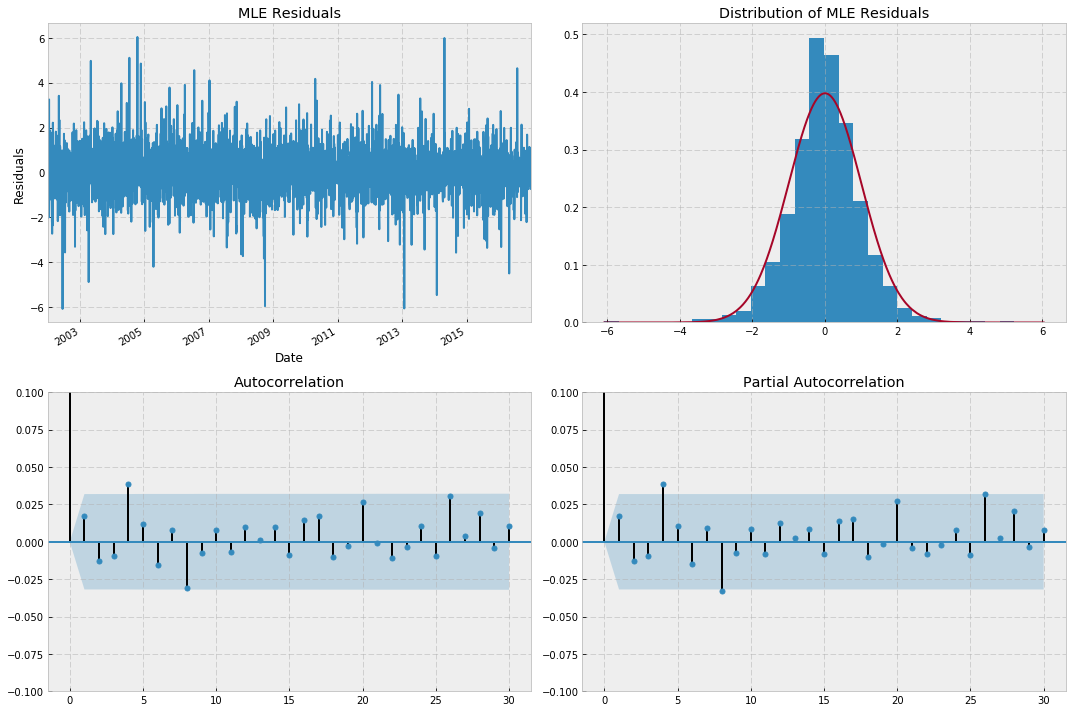

-------------------------------------------------------------------
MLE Residuals Summary Statistics:

 Mean: 0.003382
 Standard Deviation: 1.002835
 Skew: 0.012232
 Kurtosis: 6.488430

-------------------------------------------------------------------
MLE Ljung-Box Autocorrelation Test:

 H0: The random variable has zero autocorrelation at all lags

 We cannot reject H0. We have no reason to believe the residuals are autocorrelated

-------------------------------------------------------------------
MLE Jarque-Bera Normality Test:

 H0: The random variable is Normally distributed

 We reject H0. We have reason to believe the residuals are not Normally distributed



In [40]:
ResidualAnalysis("MLE")

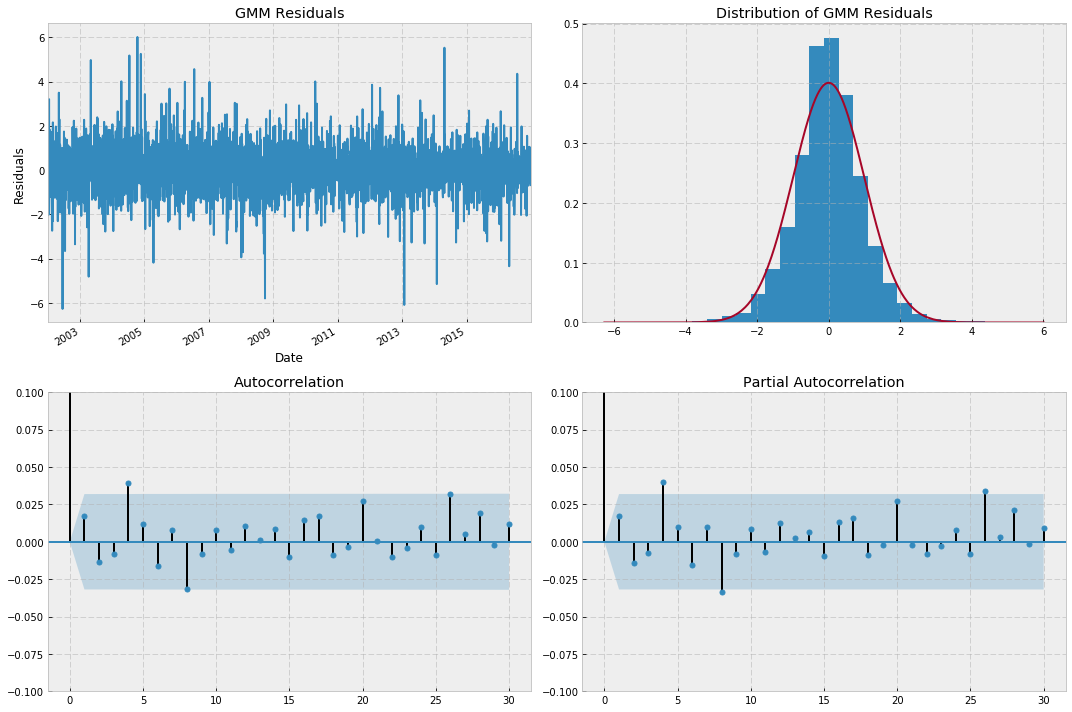

-------------------------------------------------------------------
GMM Residuals Summary Statistics:

 Mean: 0.003301
 Standard Deviation: 0.995089
 Skew: 0.017803
 Kurtosis: 6.448773

-------------------------------------------------------------------
GMM Ljung-Box Autocorrelation Test:

 H0: The random variable has zero autocorrelation at all lags

 We cannot reject H0. We have no reason to believe the residuals are autocorrelated

-------------------------------------------------------------------
GMM Jarque-Bera Normality Test:

 H0: The random variable is Normally distributed

 We reject H0. We have reason to believe the residuals are not Normally distributed



In [41]:
ResidualAnalysis("GMM")

Both sets of parameters perform similarly. The time series plots now look much more like our simple independent GBM model. This is supported by the ACF and PACF plots, though the autocorrelation at lag 4 seems to have persisted somewhat. Nevertheless, both methods pass the Ljung-Box hypothesis test for autocorrelation.

Now turning to the distribution of the residuals, both sets of parameters have a mean and skew of approximately zero and a near unity standard deviation. However, they also both exhibit fat-tails that rule them out as being Normally distributed, hence why they fail the Jarque-Bera hypothesis test.

The function ResidualVolAnalysis() below looks more closely at the variance of the residuals as a function of time.

In [10]:
def ResidualVolAnalysis(method):
    
    theta = optimal_theta[method]
    residuals = getResiduals(theta)
    sq_residuals = residuals**2
    
    plt.style.use(['bmh'])
    
    fig = plt.figure( figsize = (15, 5) )
    sq_residuals.plot()
    plt.suptitle("{} Square Residuals".format(method), fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Square Residuals")
    time_ax = plt.axes()
    time_ax.xaxis.set_major_locator(plt.LinearLocator())
    plt.show()
    
    fig = plt.figure( figsize = (15, 10) )
    layout = (2, 2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    max_lags = 30
    
    tsaplots.plot_acf( sq_residuals , lags = max_lags, ax = acf_ax, alpha = 0.05 )
    acf_ax.set_ylim([-0.1, 0.1])
    
    tsaplots.plot_pacf( sq_residuals , lags = max_lags, ax = pacf_ax, alpha = 0.05 )
    pacf_ax.set_ylim([-0.1, 0.1])

    plt.tight_layout()
    plt.show()
    
    print("-------------------------------------------------------------------")   
    
    print("{} Ljung-Box Autocorrelation Test:\n".format(method))    
    print(" H0: The random variable has zero autocorrelation at all lags\n")
    _, pvalue = box = acorr_ljungbox(sq_residuals, lags=40)
    
    if any((pvalue) < 0.05):
        print(" We reject H0. We have reason to believe the residuals are autocorrelated\n")
    else:
        print(" We cannot reject H0. We have no reason to believe the residuals are autocorrelated\n")

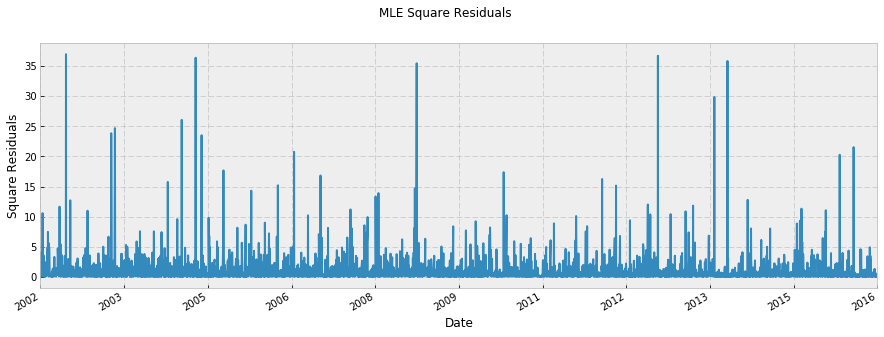

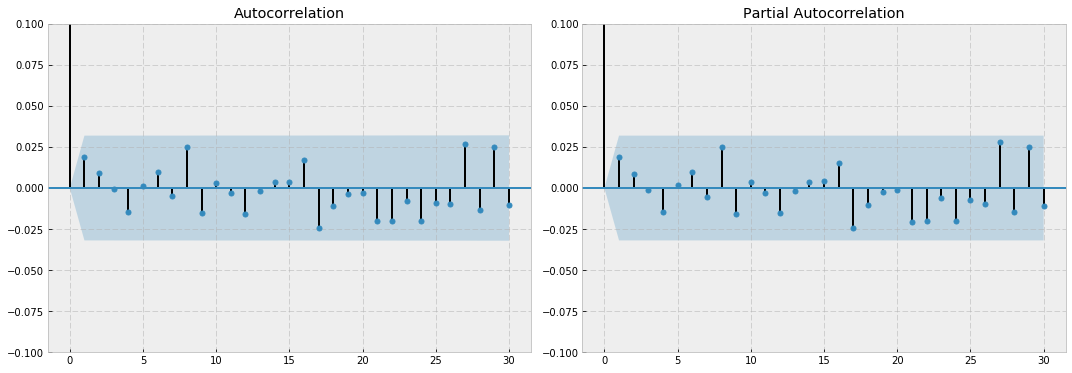

-------------------------------------------------------------------
MLE Ljung-Box Autocorrelation Test:

 H0: The random variable has zero autocorrelation at all lags

 We cannot reject H0. We have no reason to believe the residuals are autocorrelated



In [43]:
ResidualVolAnalysis("MLE")

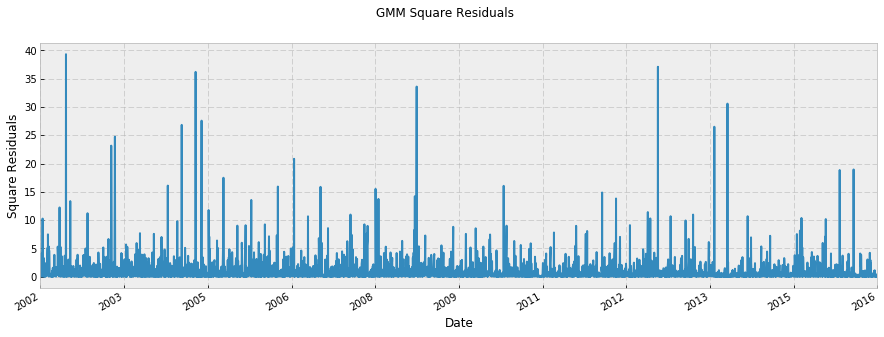

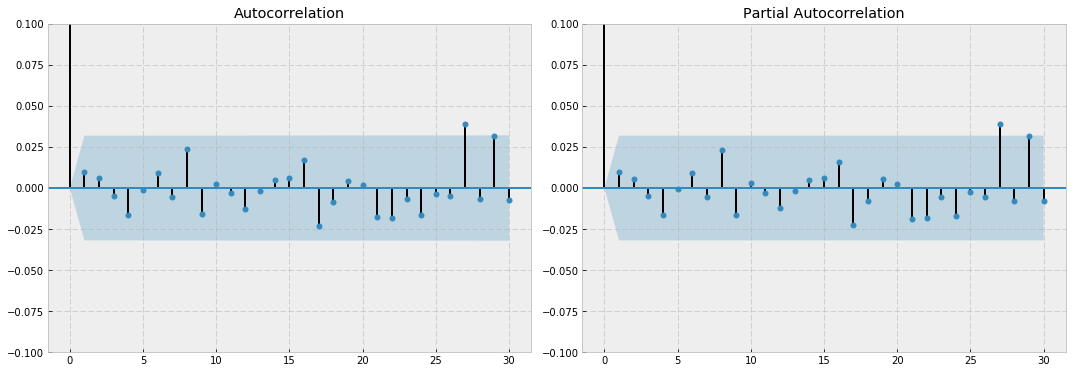

-------------------------------------------------------------------
GMM Ljung-Box Autocorrelation Test:

 H0: The random variable has zero autocorrelation at all lags

 We cannot reject H0. We have no reason to believe the residuals are autocorrelated



In [31]:
ResidualVolAnalysis("GMM")

Again both sets of parameters perform similarly. The volatility clustering that was apparent in the original returns data has been largely explained by the GARCH model. The squared-residuals pass the Ljung-Box hypothesis test and hence we can confidently say that the residuals are conditionally and unconditionally homoscedastic.

The GARCH model seems to satisfy the residuals' autocorrelation properties, however there are too many outliers for them to be Normally distributed. This is a key assumption in the derivation of our MLE method, but not for GMM. The function FitResidualsStudentDistribution() below uses an MLE method in an attempt to fit the GMM residuals to a Student's t-distribution.

In [11]:
def FitResidualsStudentDistribution():
    
    method = "GMM"
    theta = optimal_theta[method]
    
    residuals = getResiduals(theta)
    sorted_residuals = sorted(list(residuals))
    
    params = stats.t.fit(sorted_residuals)
    df = params[0]
    loc = params[1]
    scale = params[2]
    
    fit = stats.t.pdf(sorted_residuals, df, loc, scale)
    
    plt.plot(sorted_residuals, fit, '-')
    plt.hist(residuals, normed = True, bins = 20)
    plt.suptitle("Distribution of {} Residuals".format(method))
    plt.show()
    
    print("Estimated t-distribution parameters: t(mu, scale, DOF)\n")
    print(" mu = {:.8f}".format(loc))
    print(" scale = {:.8f}".format(scale))
    print(" degrees of freedom = {:.8f}".format(df))
    
    print("-------------------------------------------------------------------")   
    
    print("{} Kolmogorov–Smirnov Goodness of Fit Test:\n".format(method))    
    print(" H0: The random variable has a Student's t distribution\n")
    _, pvalue = stats.kstest(residuals, lambda x: stats.t.cdf(x, df, loc, scale)) 
    
    if (pvalue) < 0.05:
        print(" We reject H0. We have reason to believe the residuals do not follow a Student's t distribution\n")
    else:
        print(" We cannot reject H0. We have reason to believe the residuals follow a Student's t distribution\n")
        


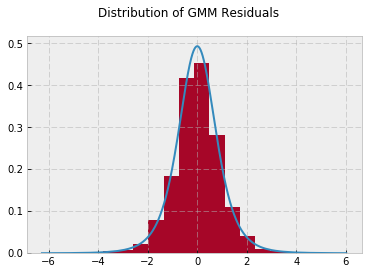

Estimated t-distribution parameters: t(mu, scale, DOF)

 mu = 0.00037530
 scale = 0.76900383
 degrees of freedom = 4.93144586
-------------------------------------------------------------------
GMM Kolmogorov–Smirnov Goodness of Fit Test:

 H0: The random variable has a Student's t distribution

 We cannot reject H0. We have reason to believe the residuals follow a Student's t distribution



In [70]:
FitResidualsStudentDistribution()

The Kolmogorov-Smirnov hypothesis test confirms that Student's t distribution is a good candidate for the residuals. 

Thus, our final model for Apple returns is GARCH(1,1) with residuals sampled from a t distribution:

$r_t = 0.00114831 + \sigma_t \epsilon_t$ $\quad$ where $\quad$ $\sigma_t^2 = 0.00001060 + 0.05917773 r_{t-1}^2 + 0.91988605 \sigma_{t-1}^2$

$\qquad\qquad\qquad\qquad\qquad\qquad\;\;\;\,\,$ $\epsilon_t$ are independent and identically distributed: $t(\mu, \sigma^2, \nu) = (0.00037530, 0.76900383, 4.93144586)$

$\qquad\qquad\qquad\qquad\qquad\qquad\;\;\;\,\,$ $\sigma_1^2 = 0.00050622$

The function CompareSeries() below simulates 15 years of Apple returns and compares this to the real market data.

In [20]:
constants = {"alpha"      : 0.05917773, 
             "beta"       : 0.91988605,
             "initial_var": 0.00050622,
             "mean"       : 0.00114831,
             "t-mean"     : 0.00037530,
             "t-scale"    : 0.76900383,
             "t-dof"      : 4.93144586 }

def simulateVol(previous_return, previous_var):
    
    const_term = (1 - constants["alpha"] - constants["beta"])*constants["initial_var"]
    
    next_var = const_term + constants["alpha"] * previous_return**2 + constants["beta"] * previous_var
    
    return next_var

def simulate_returns():
    
    dates = returns().index
    n = len(dates)
    
    residual_samples = stats.t.rvs( constants["t-dof"], constants["t-mean"], constants["t-scale"], n)
    
    simulated_returns = [0]*n
    
    simulated_vars = [0]*n
    simulated_vars[0] = constants["initial_var"]
    
    for i in range(n):
    
        simulated_returns[i] = constants["mean"] + np.sqrt( simulated_vars[i] ) *  residual_samples[i]
        
        if(i == n-1):
            break
            
        simulated_vars[i+1] = simulateVol(simulated_returns[i], simulated_vars[i])  
            
    simulated_returns = pd.Series(simulated_returns, dates)
    simulated_vars = pd.Series(simulated_vars, dates)
        
    return simulated_returns, simulated_vars

def CompareSeries():
        
    historical_returns = returns()  
    n = len(historical_returns)
    [ hist_mean, hist_std, hist_skew, hist_kurtosis ] = calculateMoments( historical_returns )
    sorted_historical_data = sorted(list(historical_returns))
    
    simulated_returns = simulate_returns()
    [ sim_mean, sim_std, sim_skew, sim_kurtosis ] = calculateMoments( simulated_returns )
    sorted_simulated_data = sorted(list(simulated_returns))
        
    plt.style.use(['bmh'])
    fig = plt.figure( figsize = (15, 20) )
    layout = (4, 2)
    max_lags = 30
    
    hist_time_series_ax = plt.subplot2grid(layout, (0, 0))
    sim_time_series_ax = plt.subplot2grid(layout, (0, 1))
    hist_histo_ax = plt.subplot2grid(layout, (1, 0))
    sim_histo_ax = plt.subplot2grid(layout, (1, 1))
    hist_acf_ax = plt.subplot2grid(layout, (2, 0))
    hist_pacf_ax = plt.subplot2grid(layout, (2, 1))
    sim_acf_ax = plt.subplot2grid(layout, (3, 0))
    sim_pacf_ax = plt.subplot2grid(layout, (3, 1))
    
    historical_returns.plot( ax = hist_time_series_ax )
    GBM_returns = pd.DataFrame( np.random.normal(hist_mean, hist_std, n) )
    GBM_returns.index = historical_returns.index
    GBM_returns.plot( ax = hist_time_series_ax, alpha = 0.4 )
    hist_time_series_ax.set_title("Daily Historical Apple Logarithmic Returns")
    hist_time_series_ax.set_xlabel("Date")
    hist_time_series_ax.set_ylabel("Logarithmic Returns")
    hist_time_series_ax.legend(["AAPL", "GBM Model"])

    simulated_returns.plot( ax = sim_time_series_ax )
    GBM_returns = pd.DataFrame( np.random.normal(sim_mean, sim_std, n) )
    GBM_returns.index = simulated_returns.index
    GBM_returns.plot( ax = sim_time_series_ax, alpha = 0.4 )
    sim_time_series_ax.set_title("Daily Simulated Apple Logarithmic Returns")
    sim_time_series_ax.set_xlabel("Date")
    sim_time_series_ax.set_ylabel("Logarithmic Returns")
    sim_time_series_ax.legend(["AAPL", "GBM Model"])
    
    historical_returns.hist( ax = hist_histo_ax, normed=True, bins = 30)
    fit = stats.norm.pdf(sorted_historical_data, hist_mean, hist_std)
    hist_histo_ax.plot(sorted_historical_data, fit, '-')
    hist_histo_ax.set_title("Distribution of historical daily Apple logarithmic returns")
    
    simulated_returns.hist( ax = sim_histo_ax, normed=True, bins = 30)
    fit = stats.norm.pdf(sorted_simulated_data, sim_mean, sim_std)
    sim_histo_ax.plot(sorted_simulated_data, fit, '-')
    sim_histo_ax.set_title("Distribution of simulated daily Apple logarithmic returns")
    
    tsaplots.plot_acf( historical_returns , lags = max_lags, ax = hist_acf_ax, alpha = 0.05 )
    hist_acf_ax.set_ylim([-0.1, 0.1])
    hist_acf_ax.set_title("Historical ACF")
    
    tsaplots.plot_pacf( historical_returns , lags = max_lags, ax = hist_pacf_ax, alpha = 0.05 )
    hist_pacf_ax.set_ylim([-0.1, 0.1])
    hist_pacf_ax.set_title("Historical PACF")
    
    tsaplots.plot_acf( simulated_returns , lags = max_lags, ax = sim_acf_ax, alpha = 0.05 )
    sim_acf_ax.set_ylim([-0.1, 0.1])
    sim_acf_ax.set_title("Simulated ACF")
    
    tsaplots.plot_pacf( simulated_returns , lags = max_lags, ax = sim_pacf_ax, alpha = 0.05 )
    sim_pacf_ax.set_ylim([-0.1, 0.1])
    sim_pacf_ax.set_title("Simulated PACF")

    plt.tight_layout()
    plt.show()
    
    print("Historical Returns Summary Statistics:\n")
    
    string_1 = " Mean: {:.6f}\n Standard Deviation: {:.6f}\n".format(hist_mean, hist_std)
    string_2 = " Skew: {:.6f}\n Kurtosis: {:.6f}\n".format(hist_skew, hist_kurtosis)
    print( string_1 + string_2 )
    
    print("Simulated Returns Summary Statistics:\n")
    
    string_1 = " Mean: {:.6f}\n Standard Deviation: {:.6f}\n".format(sim_mean, sim_std)
    string_2 = " Skew: {:.6f}\n Kurtosis: {:.6f}\n".format(sim_skew, sim_kurtosis)
    print( string_1 + string_2 )
    

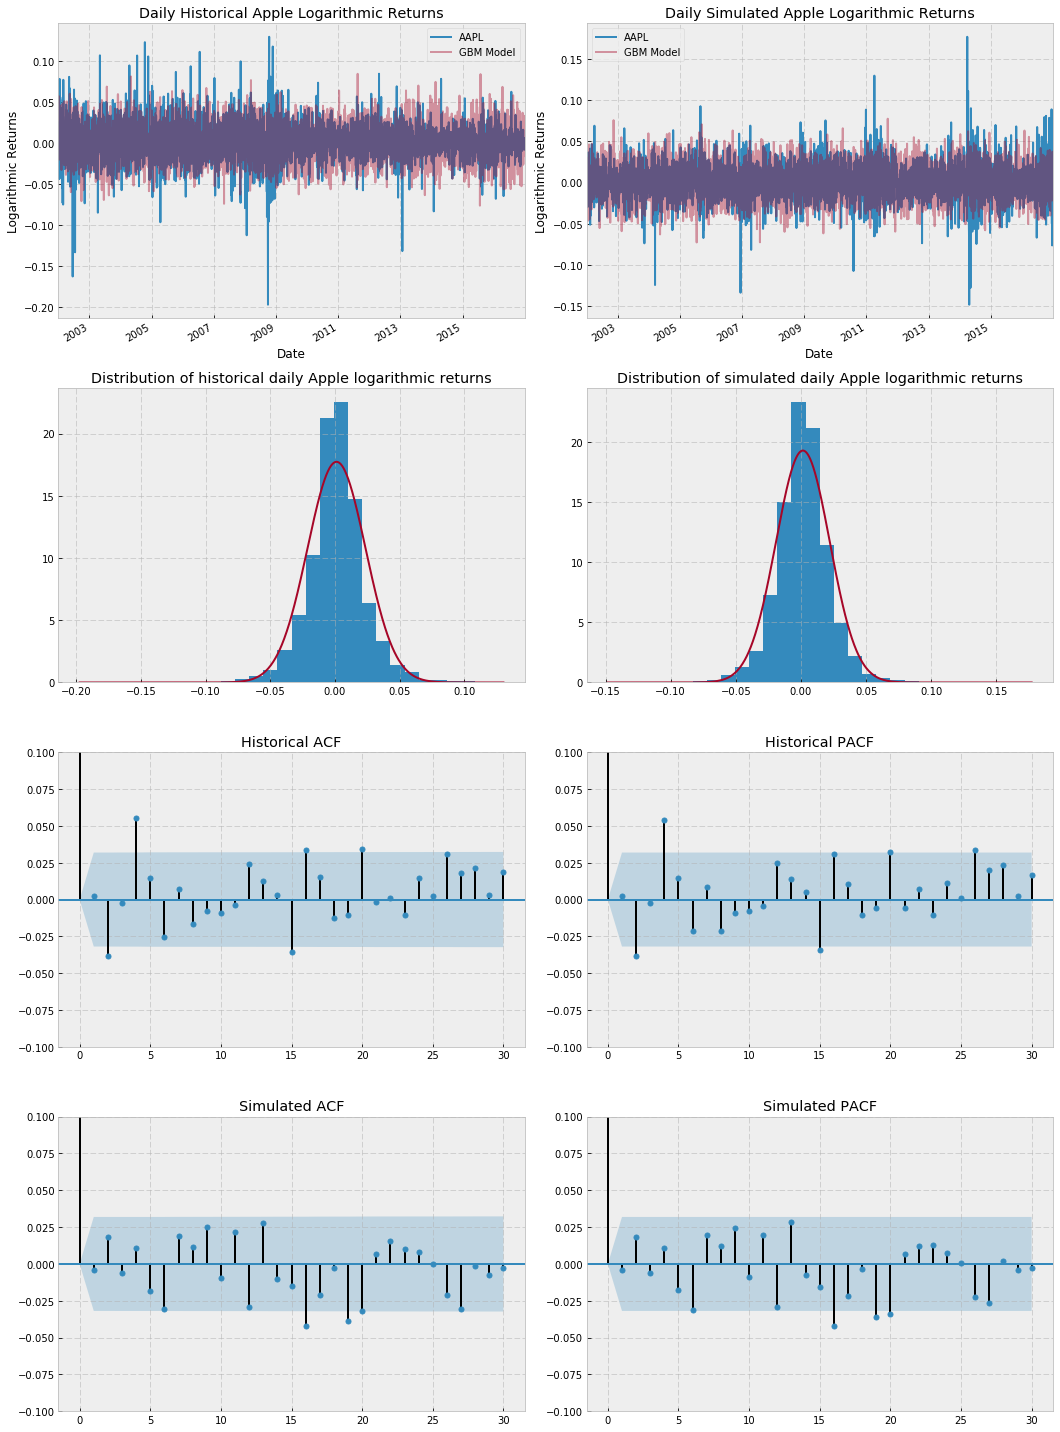

Historical Returns Summary Statistics:

 Mean: 0.001148
 Standard Deviation: 0.022499
 Skew: -0.178401
 Kurtosis: 8.363240

Simulated Returns Summary Statistics:

 Mean: 0.001446
 Standard Deviation: 0.020658
 Skew: 0.029637
 Kurtosis: 8.120673



In [217]:
CompareSeries()

Whilst there is a deterministic element to the volatilty model, the residuals are still being randomly sampled to generate the simulation. For this reason we would not expect the model to trace out the real time sequence. Nevertheless the simulated heteroscedastic volatility compares better, at least qualitatively, to the market data than the classical GBM model.

The returns distributions visually appear similar and have comparable mean, standard deviation and kurtosis - although the higher order statistics in particular can vary quite substantially when resampled. Our model has a skew of zero since $\sigma_t^2$ is indifferent to the sign of returns (depending only on $r_t^2$) and a t-distribution is symmetric. This prevents us from modelling the negative skew in the market data.

The historical data also features weak memory effects at lags 2, 4 and 15. These are not specifically reflected in the simulated data, though, again, this can vary significantly when resampled.

The function CompareVol() below produces plots for the square mean-adjusted returns.

In [196]:
def CompareVol():
    
    historical_returns = returns()
    historical_sq_returns = (historical_returns - np.mean(historical_returns) )**2
    
    simulated_returns = simulate_returns()
    simulated_sq_returns = (simulated_returns - np.mean(simulated_returns) )**2
    
    plt.style.use(['bmh'])
    
    fig = plt.figure( figsize = (15, 5) )
    historical_sq_returns.plot()
    plt.suptitle("Daily Historical Apple Square Mean-Adjusted Logarithmic Returns", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Square Logarithmic Returns")
    time_ax = plt.axes()
    time_ax.xaxis.set_major_locator(plt.LinearLocator())
    time_ax.set_ylim([0, 0.04])
    plt.show()
    
    fig = plt.figure( figsize = (15, 5) )
    simulated_sq_returns.plot()
    plt.suptitle("Daily Simulated Apple Square Mean-Adjusted Logarithmic Returns", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Square Logarithmic Returns")
    time_ax = plt.axes()
    time_ax.xaxis.set_major_locator(plt.LinearLocator())
    time_ax.set_ylim([0, 0.04])
    plt.show()
    
    fig = plt.figure( figsize = (15, 20) )
    layout = (4, 2)
    hist_acf_ax = plt.subplot2grid(layout, (1, 0))
    hist_pacf_ax = plt.subplot2grid(layout, (1, 1))
    sim_acf_ax = plt.subplot2grid(layout, (2, 0))
    sim_pacf_ax = plt.subplot2grid(layout, (2, 1))
    max_lags = 30
    
    tsaplots.plot_acf( historical_sq_returns , lags = max_lags, ax = hist_acf_ax, alpha = 0.05 )
    hist_acf_ax.set_title("Historical ACF")
    
    tsaplots.plot_pacf( historical_sq_returns , lags = max_lags, ax = hist_pacf_ax, alpha = 0.05 )
    hist_pacf_ax.set_title("Historical PACF")
    
    tsaplots.plot_acf( simulated_sq_returns , lags = max_lags, ax = sim_acf_ax, alpha = 0.05 )
    sim_acf_ax.set_title("Simulated ACF")
    
    tsaplots.plot_pacf( simulated_sq_returns , lags = max_lags, ax = sim_pacf_ax, alpha = 0.05 )
    sim_pacf_ax.set_title("Simulated PACF")

    plt.tight_layout()
    plt.show()

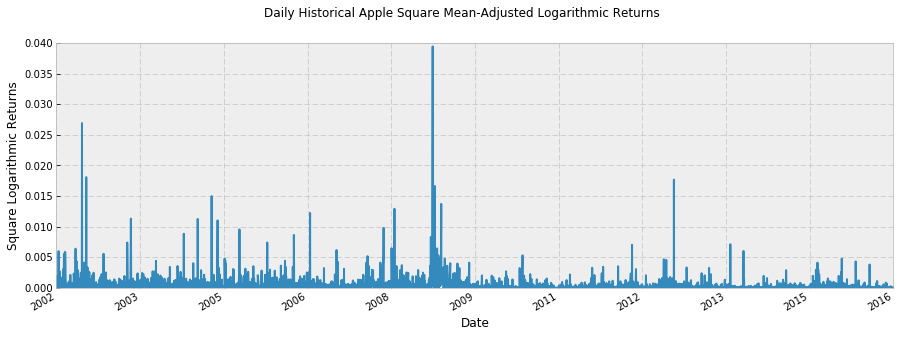

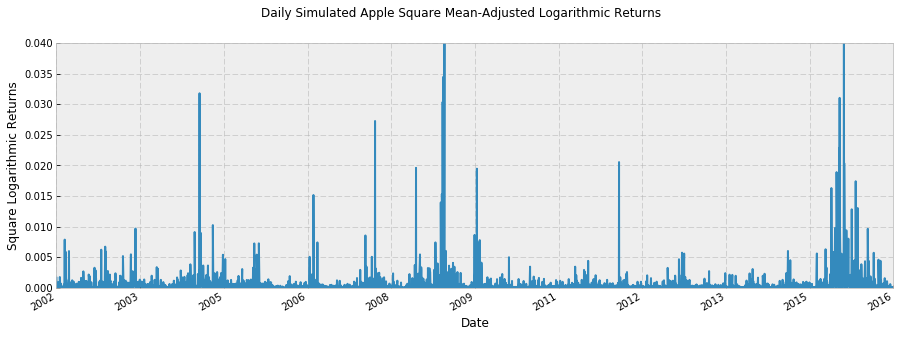

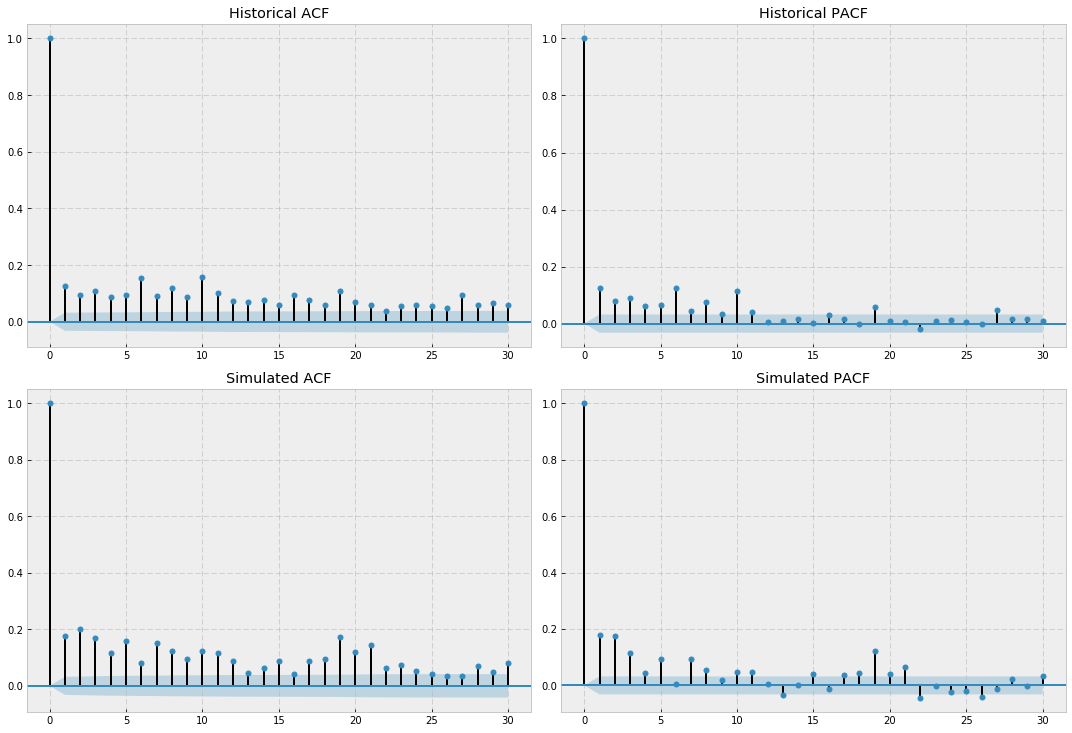

In [197]:
CompareVol()

Both the historical and simulated data feature a slowly decaying ACF but finite PACF, confirming that the model has well captured the volatility clustering.

**Conclusions**

Our final model is far from perfect. Resorting to retrofitting the residuals as non-Normal suggests that the model is fundamentally incomplete.

The relatively simple GARCH(1,1) model seems to well explain the volatility memory in the Apple returns. Whilst this volatility model did generate a leptokurtic returns distribution, we were forced to remodel the residuals in order to match the fat-tails in the market data. A more scientific approach might have been to model the discontinuities or shocks within the asset price - [QGARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity#QGARCH) attempts this.

We have not managed to explain the negative skew evident within the returns distribution. We could simply apply another sticking plaster, as we did to match the fat-tails, and remodel the residuals with an asymmetric distribution. A more satisfying and robust approach might be to revisit the symmetry inherent in the volatility model. This symmetry prevents us from capturing the commonly observed *leverage effect*: the tendency for downward asset moves to occur more violently than upward moves. This results in a volatility that is negatively correlated to returns. By incorporating this accepted phenomonen into our model, we could simultaneously explain the negative skew in the returns distribuion - [NAGARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity#NAGARCH) attempts this.

Finally, the first-order memory effects within the returns data appear to be poorly modelled. Perhaps an ARMA process could be included to capture this feature:

$r_t = \text{ARMA}(p,q) + \sigma_t\epsilon_t$

This might have the added benefit of better modelling the fat-tails and skew within the returns distribution.

Whilst it was Mandelbrot that first observed volatility clustering, he considered the GARCH framework unscientific and instead developed a fractal model of asset returns - [Mandelbrot](https://users.math.yale.edu/~bbm3/web_pdfs/Cowles1164.pdf).

With more research, this model could be improved to increase its statistical power. Such a model could be used to predict daily price moves in a trading strategy, perhaps updating its parameters weekly: buy if the price is predicted to go up, otherwise sell. More sophisticated algorithms can be devised, but all should be backtested out-of-sample and compared against a simple buy-and-hold strategy.

The recurrent GARCH volatility model is also used in options trading to solely forecast volatility, however the parameters are not estimated using historical returns data as we have done here. This is because historical/realised volatility is taken over the physical returns distribution whereas implied volatility, as determined from market option prices and the Black-Scholes formula, is theorised from a risk-neutral distribution. Implied volatility is often higher than realised volatility. The difference is called the *volatility risk premium* and represents the compensation that investors demand to bear risks associated with uncertain future volatility. Instead traders calibrate GARCH parameters to implied volatility and then use the model to predict it. This helps them to identify and exploit undervalued options in the market.

This is in contrast to continuous-time stochastic volatility models, such as Heston, that are calibrated against vanilla market prices and then used to price more exotic products. Though some work has focussed on incorporating GARCH into a risk-neutral option pricing framework by introducing a risk premium parameter - [Duan](https://rmi.nus.edu.sg/duanjc/index_files/files/opm_sv.pdf).

Lastly, a GARCH model of asset returns can be used to simulate its entire distribution over some time period and hence estimate risk metrics like VaR and cVaR.